In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# Define the stock symbol
stock = 'AAPL'

# Get the historical stock prices from Yahoo Finance
data_full = pd.DataFrame(yf.download(stock, start='2019-01-01', end='2022-02-26'))
data_full.loc[:,'Return'] = np.log(data_full['Close']).diff()
# Return if i buy on open and sell on close
data_full.loc[:,'OCReturn'] = np.log(data_full.loc[:,'Open'])-np.log(data_full.loc[:,'Close'])

[*********************100%%**********************]  1 of 1 completed


### moving average crossover

In [2]:
# Calculate the SMAs
# On the 20th day we get the SMA20 value by considering the whole bar passed.
# so we shift one day the indicators to avoid leakage
short_period = 20
long_period = 50
data_full[f'SMA{short_period}'] = data_full['Close'].rolling(window=short_period).mean().shift()
data_full[f'SMA{long_period}'] = data_full['Close'].rolling(window=long_period).mean().shift()
data = data_full.dropna()
data.head()

,Open,High,Low,Close,Adj Close,Volume,Return,OCReturn,SMA20,SMA50
Date,,,,,,,,,,
2019-03-15,46.212502,46.832500,45.935001,46.529999,44.632881,156171600,0.012924,-0.006847,43.704000,41.35925
2019-03-18,46.450001,47.097500,46.447498,47.005001,45.088516,104879200,0.010157,-0.011878,43.895500,41.50025
2019-03-19,47.087502,47.247501,46.480000,46.632500,44.731201,126585600,-0.007956,0.009710,44.115500,41.72940
2019-03-20,46.557499,47.372501,46.182499,47.040001,45.122086,124140800,0.008701,-0.010310,44.310500,41.92075
2019-03-21,47.505001,49.082500,47.452499,48.772499,46.783943,204136800,0.036168,-0.026332,44.512125,42.12190


In [3]:
#Get the buy signals +1
data.loc[:,'Signal']  = np.where(data[f'SMA{short_period}'] > data[f'SMA{long_period}'], 1, 0)
#Get the sell signals -1
data.loc[:,'Signal'] = np.where(data[f'SMA{short_period}'] < data[f'SMA{long_period}'], -1, data['Signal'])

#Get the position
data.loc[:,'Position'] = data.loc[:,'Signal'].diff() # current - previous
data.loc[:,'Position'] = data.loc[:,'Position'].fillna(2 if data.loc[data.index[0],'Signal'] == 1 else -2)
data.head()

C:\Users\User\AppData\Local\Temp\ipykernel_12404\475478552.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:,'Signal']  = np.where(data[f'SMA{short_period}'] > data[f'SMA{long_period}'], 1, 0)
C:\Users\User\AppData\Local\Temp\ipykernel_12404\475478552.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:,'Position'] = data.loc[:,'Signal'].diff() # current - previous


,Open,High,Low,Close,Adj Close,Volume,Return,OCReturn,SMA20,SMA50,Signal,Position
Date,,,,,,,,,,,,
2019-03-15,46.212502,46.832500,45.935001,46.529999,44.632881,156171600,0.012924,-0.006847,43.704000,41.35925,1,2.0
2019-03-18,46.450001,47.097500,46.447498,47.005001,45.088516,104879200,0.010157,-0.011878,43.895500,41.50025,1,0.0
2019-03-19,47.087502,47.247501,46.480000,46.632500,44.731201,126585600,-0.007956,0.009710,44.115500,41.72940,1,0.0
2019-03-20,46.557499,47.372501,46.182499,47.040001,45.122086,124140800,0.008701,-0.010310,44.310500,41.92075,1,0.0
2019-03-21,47.505001,49.082500,47.452499,48.772499,46.783943,204136800,0.036168,-0.026332,44.512125,42.12190,1,0.0


In [4]:
buy_price = data[data['Position']==2]['Close']
sell_price = data[data['Position']==-2]['Close']

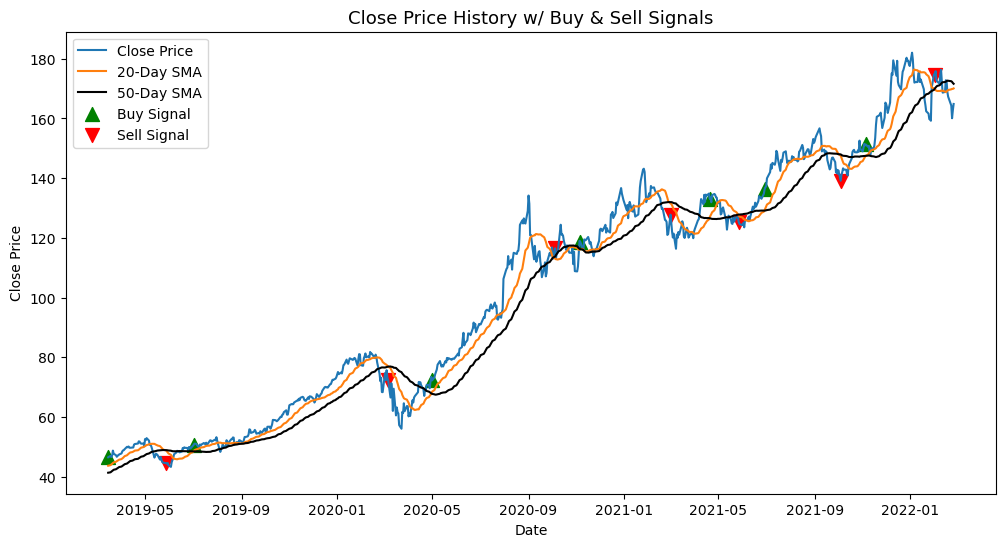

In [5]:
fig, ax = plt.subplots(figsize=(12,6))
plt.title('Close Price History w/ Buy & Sell Signals', fontsize=13)
ax.plot(data.index, data['Close'], label='Close Price')
ax.plot(data.index, data[f'SMA{short_period}'], label=f'{short_period}-Day SMA')
ax.plot(data.index, data[f'SMA{long_period}'], label=f'{long_period}-Day SMA', color = 'black')
ax.scatter(buy_price.index, buy_price, alpha = 1, label='Buy Signal', marker = '^', s=100, color = 'green')
ax.scatter(sell_price.index, sell_price, alpha = 1, label='Sell Signal', marker = 'v', s=100, color = 'red')
ax.set_xlabel('Date', fontsize=10)
ax.set_ylabel('Close Price', fontsize=10)
ax.legend()
plt.show()

In [6]:
# Strategy return if i buy on open and sell on close
data.loc[:,'OCStrategy_Return'] = data.loc[:,'Signal'] * data.loc[:,'OCReturn']

data.loc[:,'Strategy_Return'] = data.loc[:,'Signal'] * data.loc[:,'Return']
data.head()

C:\Users\User\AppData\Local\Temp\ipykernel_12404\1193577739.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:,'OCStrategy_Return'] = data.loc[:,'Signal'] * data.loc[:,'OCReturn']
C:\Users\User\AppData\Local\Temp\ipykernel_12404\1193577739.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:,'Strategy_Return'] = data.loc[:,'Signal'] * data.loc[:,'Return']


,Open,High,Low,Close,Adj Close,Volume,Return,OCReturn,SMA20,SMA50,Signal,Position,OCStrategy_Return,Strategy_Return
Date,,,,,,,,,,,,,,
2019-03-15,46.212502,46.832500,45.935001,46.529999,44.632881,156171600,0.012924,-0.006847,43.704000,41.35925,1,2.0,-0.006847,0.012924
2019-03-18,46.450001,47.097500,46.447498,47.005001,45.088516,104879200,0.010157,-0.011878,43.895500,41.50025,1,0.0,-0.011878,0.010157
2019-03-19,47.087502,47.247501,46.480000,46.632500,44.731201,126585600,-0.007956,0.009710,44.115500,41.72940,1,0.0,0.009710,-0.007956
2019-03-20,46.557499,47.372501,46.182499,47.040001,45.122086,124140800,0.008701,-0.010310,44.310500,41.92075,1,0.0,-0.010310,0.008701
2019-03-21,47.505001,49.082500,47.452499,48.772499,46.783943,204136800,0.036168,-0.026332,44.512125,42.12190,1,0.0,-0.026332,0.036168


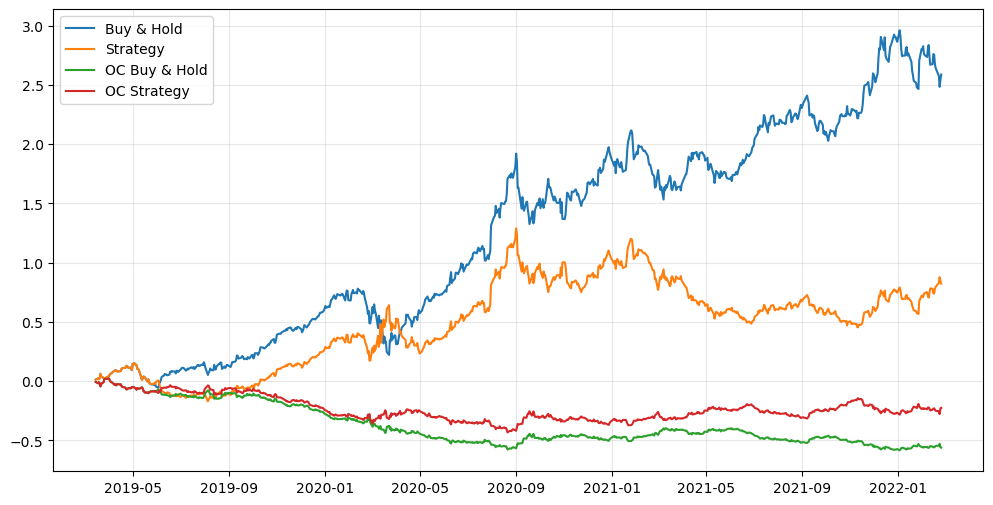

In [7]:
plt.figure(figsize=(12,6))
plt.plot(np.exp(data['Return']).cumprod()-1, label='Buy & Hold')
plt.plot(np.exp(data['Strategy_Return']).cumprod()-1, label='Strategy')
plt.plot(np.exp(data['OCReturn']).cumprod()-1, label='OC Buy & Hold')
plt.plot(np.exp(data['OCStrategy_Return']).cumprod()-1, label='OC Strategy')
plt.legend(loc=2)
plt.grid(True, alpha=.3)

In [8]:
print("Sharpe Ration for the buy and hold: ",data['Return'].mean()*252**0.5/data['Return'].std())
print("Sharpe Ration for the strategy: ",data['Strategy_Return'].mean()*252**0.5/data['Strategy_Return'].std())

Sharpe Ration for the buy and hold:  1.2742561898484508
Sharpe Ration for the strategy:  0.5975695758701589


In [9]:
buy_price

Date
2019-03-15     46.529999
2019-07-02     50.682499
2020-05-01     72.267502
2020-11-06    118.690002
2021-04-20    133.110001
2021-06-29    136.330002
2021-11-05    151.279999
Name: Close, dtype: float64

In [10]:
fig = make_subplots(rows=3, cols = 1, shared_xaxes=True, row_heights = [0.7, 0.3, 0.3], vertical_spacing=0.05)

fig.add_trace(go.Candlestick(x=data.index,
    open=data.iloc[:,0], high= data.iloc[:,1],
    low=data.iloc[:,2], close=data.iloc[:,3] ,
    increasing_line_color= 'green', decreasing_line_color= 'red')
)

fig.update_layout(xaxis_rangeslider_visible=False, template="plotly_dark")
fig.update_layout(yaxis_title = f"{stock} price (USD)", xaxis_title = "Date")

fig.add_trace(go.Scatter(
            # x=trades.entry_time,
            # y=trades.entry_price,
            x=buy_price.index,
            y=buy_price,
            mode = "markers",
            customdata=buy_price,
            marker_symbol="diamond-dot",
            marker_size = 13,
            marker_line_width = 2,
            marker_line_color = "rgba(0,0,0,0.7)",
            marker_color="rgba(0,255,0,0.7)",
            hovertemplate="Entry Time: %{customdata[1]}<br>" +\
                            "Entry Price: %{y:.2f}<br>" +\
                            "Size: %{customdata[2]:.5f}<br>" +\
                            "Profit_pct: %{customdata[5]:.3f}",
            name="Entries" #Buy or Sell Signals
))

fig.add_trace(go.Scatter(
            x=sell_price.index,
            y=sell_price,
            mode = "markers",
            customdata=sell_price,
            marker_symbol="diamond-dot",
            marker_size = 13,
            marker_line_width = 2,
            marker_line_color = "rgba(0,0,0,0.7)",
            marker_color="rgba(255,0,0,0.7)",
            hovertemplate="Exit Time: %{customdata[4]}<br>" +\
                            "Exit Price: %{y:.2f}<br>" +\
                            "Size: %{customdata[2]:.5f}<br>" +\
                            "Profit_pct: %{customdata[5]:.3f}",
            name="Exits"
))

# fig.update_yaxes(type="log")

fig.add_trace(
    go.Scatter(x=data.index, y=data[f"SMA{long_period}"], name=f"SMA{long_period}"), row=2,col=1
)
fig.add_trace(
    go.Bar(x=data.index, y=data['Volume'], name="Volume",  marker=dict(color='rgb(255, 255, 255)') ,
           ),  row=3,col=1
)
#Plot the Volume
# bottom = plt.subplot2grid((4,4), (3,0), rowspan=1, colspan=4)
# plt.title('Volume 2019 - 2021')
# bottom.bar(data.index, data['Volume'])
# plt.subplots_adjust(hspace=0.75)

fig.update_layout(height=600, width=1200)
fig.show()